# Notebook to test SetFit performance

Check CUDA

In [32]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Load dataset and transform data

In [33]:
import pandas as pd
import numpy as np

dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')

In [34]:
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset['label'] = np.where((subset["label"] < 3) | (subset["label"].isna()), 0, 1)
subset = subset[['text','label']]
subset

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


Split between training and test set and truncate the dataset to simulate few-shot context

In [35]:
from datasets import Dataset

def split_train_test(dataset, ratio):
    test_set = dataset.sample(frac = ratio)
    train_set = dataset.drop(test_set.index)
    return train_set, test_set

train_set, test_set = split_train_test(subset, 0.2)

train_ds = Dataset.from_pandas(train_set, split="train")
test_ds = Dataset.from_pandas(test_set, split="test")

In [36]:
from setfit import sample_dataset

train_dataset = sample_dataset(train_ds, label_column="label", num_samples=10)
test_dataset = test_ds
print(train_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 20
})


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Load a pre trained sentence transformers to be used by SetFit

In [37]:
from setfit import SetFitModel

# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model.to("cuda")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


SetFitModel(model_body=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
), model_head=LogisticRegression(), multi_target_strategy=None, normalize_embeddings=False, labels=None, model_card_data=SetFitModelCardData(language=None, license=None, tags=['setfit', 'sentence-transformers', 'text-classification', 'generated_from_setfit_trainer'], model_name='SetFit with sentence-transformers/paraphrase-mpnet-base-v2', model_id=None, dataset_name=None, dataset_id=None, dataset_revision=None, task_name=None, st_id='sentence-transformers/paraphrase-mpnet-base-v2', hyperparameters={}, eval_results_dict={}, eval_lines_list=[], metric_l

In [38]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score

# Create trainer

def compute_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return { 'accuracy': accuracy, 'f1': f1}

trainer_arguments = TrainingArguments(
	loss=CosineSimilarityLoss,
    batch_size=(8,2),
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
)

trainer = Trainer(
    model=model,
    args=trainer_arguments,
    metric=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Training and evaluation

In [39]:
# trainer.train()

How to save/load the fine tuned model

In [40]:
# metrics = trainer.evaluate()
# metrics

In [41]:
# model._save_pretrained(r'../models/setfit') # The given folder must exist

In [42]:
# model = SetFitModel._from_pretrained(r'../models/setfit')

A small example on unseen data

In [43]:
# preds = model(["Mon rôle chez DreamQuark, est de résoudre les problématiques des différents acteurs autour de la\nbanque et assurance (Churn, upsale, cross-sale etc.) à travers des techniques de Machine\nLearning/Deep learning","• Utilisation de Flask et d’Elasticsearch afin de créer une API\nREST pour faire des recherches sur des régions de\nplanètes."])
# print("predictions: ", preds,"expected: ",[1,0])

Free memory

In [44]:
del model
torch.cuda.empty_cache()

# Tests on hyper parameters

In [45]:
def get_train_set(train_ds, n_shots, min_text_length=None, max_text_length=None):
    if n_shots <= 0:
        raise Exception("Invalid n_shots value")
    if min_text_length is None:
        if max_text_length is None:
            train_ds_length_constraint = train_ds
        else:
            train_ds_length_constraint = train_ds[train_ds['text'].str.len() >= min_text_length]
    else:
        if max_text_length is None:
            train_ds_length_constraint = train_ds[train_ds['text'].str.len() <= max_text_length]
        else:
            train_ds_length_constraint = train_ds[train_ds['text'].str.len().between(min_text_length, max_text_length)]
    return sample_dataset(train_ds_length_constraint, label_column="label", num_samples=n_shots)

def get_transformer_model(model_name):
    model = SetFitModel.from_pretrained(model_name)
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset):
    trainer_arguments = TrainingArguments(
        loss=loss,
        batch_size=(8,2),
        num_iterations=20, # Number of text pairs to generate for contrastive learning
        num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    return trainer

def setfit_f1_score(train_ds, test_ds, min_text_length, max_text_length, n_shots, model_name, loss):
    train_dataset = get_train_set(train_ds, n_shots, min_text_length, max_text_length)
    model = get_transformer_model(model_name)
    trainer = init_trainer(model, loss, train_dataset, test_ds)
    trainer.train()
    metrics = trainer.evaluate()
    
    del model
    torch.cuda.empty_cache()
    
    return metrics['f1']

## N-Shots

In [47]:
results = []
n_values = [1,5,10,15,20]

for i in n_values:
	results.append(setfit_f1_score(train_ds, test_ds, None, None, i, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss))

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.0293, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 3.8929, 'train_samples_per_second': 20.55, 'train_steps_per_second': 2.569, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.2009, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.002, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 31.528, 'train_samples_per_second': 12.687, 'train_steps_per_second': 1.586, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.1842, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.0039, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0009, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 92.4891, 'train_samples_per_second': 8.65, 'train_steps_per_second': 1.081, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1200
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 150


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

{'embedding_loss': 0.2698, 'learning_rate': 1.3333333333333334e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.33}
{'embedding_loss': 0.0002, 'learning_rate': 7.4074074074074075e-06, 'epoch': 0.67}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 226.466, 'train_samples_per_second': 5.299, 'train_steps_per_second': 0.662, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.3165, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.0069, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0005, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0003, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0005, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 693.7895, 'train_samples_per_second': 2.306, 'train_steps_per_second': 0.288, 'epoch': 1.0}


***** Running evaluation *****


In [48]:
results

[0.29061371841155237,
 0.6462167689161554,
 0.6954813359528488,
 0.7017543859649122,
 0.6691312384473198]

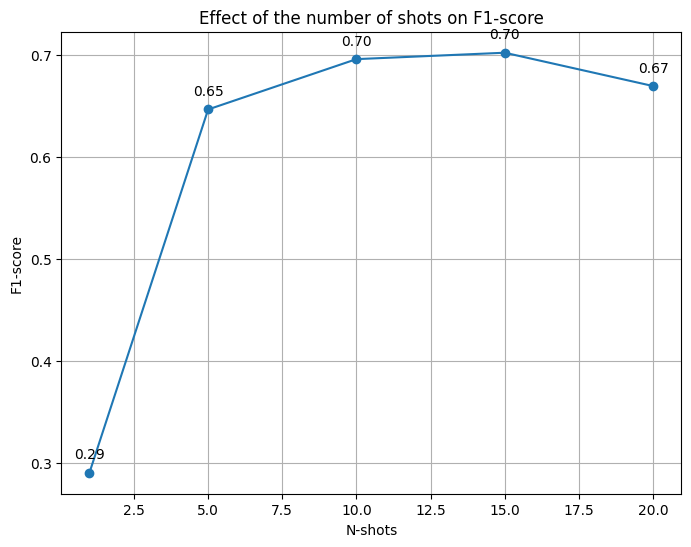

In [49]:
import matplotlib.pyplot as plt
 
x = n_values
y = results
 
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-')
 
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(f'{yi:.2f}', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')
 
plt.title('Effect of the number of shots on F1-score')
plt.xlabel('N-shots')
plt.ylabel('F1-score')
 
plt.grid(True)
plt.show()